In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from model import loader
from model.modules import Guided_Upsampling_Block
from data.datasets import get_dataloader
from data import transforms

# DDRNET_23_slim

In [2]:
BatchNorm2d = nn.BatchNorm2d
bn_mom = 0.1

def depthwise(in_channels, kernel_size):
    padding = (kernel_size-1) // 2
    assert 2*padding == kernel_size-1, "parameters incorrect. kernel={}, padding={}".format(kernel_size, padding)
    return nn.Sequential(
          nn.Conv2d(in_channels,in_channels,kernel_size,stride=1,padding=padding,bias=False,groups=in_channels),
          nn.BatchNorm2d(in_channels),
          nn.ReLU(inplace=True),
        )

def pointwise(in_channels, out_channels):
    return nn.Sequential(
          nn.Conv2d(in_channels,out_channels,1,1,0,bias=False),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(inplace=True),
        )

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None, no_relu=False):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = BatchNorm2d(planes, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = BatchNorm2d(planes, momentum=bn_mom)
        self.downsample = downsample
        self.stride = stride
        self.no_relu = no_relu

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual

        if self.no_relu:
            return out
        else:
            return self.relu(out)

class Bottleneck(nn.Module):
    expansion = 2

    def __init__(self, inplanes, planes, stride=1, downsample=None, no_relu=True):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = BatchNorm2d(planes, momentum=bn_mom)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = BatchNorm2d(planes, momentum=bn_mom)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1,
                               bias=False)
        self.bn3 = BatchNorm2d(planes * self.expansion, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.no_relu = no_relu

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        if self.no_relu:
            return out
        else:
            return self.relu(out)

class DAPPM(nn.Module):
    def __init__(self, inplanes, branch_planes, outplanes):
        super(DAPPM, self).__init__()
        self.scale1 = nn.Sequential(nn.AvgPool2d(kernel_size=5, stride=2, padding=2),
                                    BatchNorm2d(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale2 = nn.Sequential(nn.AvgPool2d(kernel_size=9, stride=4, padding=4),
                                    BatchNorm2d(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale3 = nn.Sequential(nn.AvgPool2d(kernel_size=17, stride=8, padding=8),
                                    BatchNorm2d(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale4 = nn.Sequential(nn.AdaptiveAvgPool2d((1, 1)),
                                    BatchNorm2d(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.scale0 = nn.Sequential(
                                    BatchNorm2d(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, branch_planes, kernel_size=1, bias=False),
                                    )
        self.process1 = nn.Sequential(
                                    BatchNorm2d(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process2 = nn.Sequential(
                                    BatchNorm2d(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process3 = nn.Sequential(
                                    BatchNorm2d(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.process4 = nn.Sequential(
                                    BatchNorm2d(branch_planes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes, branch_planes, kernel_size=3, padding=1, bias=False),
                                    )
        self.compression = nn.Sequential(
                                    BatchNorm2d(branch_planes * 5, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(branch_planes * 5, outplanes, kernel_size=1, bias=False),
                                    )
        self.shortcut = nn.Sequential(
                                    BatchNorm2d(inplanes, momentum=bn_mom),
                                    nn.ReLU(inplace=True),
                                    nn.Conv2d(inplanes, outplanes, kernel_size=1, bias=False),
                                    )

    def forward(self, x):

        #x = self.downsample(x)
        width = x.shape[-1]
        height = x.shape[-2]
        x_list = []

        x_list.append(self.scale0(x))
        x_list.append(self.process1((F.interpolate(self.scale1(x),
                        size=[height, width],
                        mode='bilinear')+x_list[0])))
        x_list.append((self.process2((F.interpolate(self.scale2(x),
                        size=[height, width],
                        mode='bilinear')+x_list[1]))))
        x_list.append(self.process3((F.interpolate(self.scale3(x),
                        size=[height, width],
                        mode='bilinear')+x_list[2])))
        x_list.append(self.process4((F.interpolate(self.scale4(x),
                        size=[height, width],
                        mode='bilinear')+x_list[3])))
        out = self.compression(torch.cat(x_list, 1)) + self.shortcut(x)
        return out


class segmenthead(nn.Module):
    def __init__(self, inplanes, interplanes, outplanes, scale_factor=None):
        super(segmenthead, self).__init__()
        self.bn1 = BatchNorm2d(inplanes, momentum=bn_mom)
        self.conv1 = nn.Conv2d(inplanes, interplanes, kernel_size=3, padding=1, bias=False)
        self.bn2 = BatchNorm2d(interplanes, momentum=bn_mom)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(interplanes, outplanes, kernel_size=1, padding=0, bias=True)
        self.scale_factor = scale_factor

    def forward(self, x):
        x = self.conv1(self.relu(self.bn1(x)))
        out = self.conv2(self.relu(self.bn2(x)))

        if self.scale_factor is not None:
            height = x.shape[-2] * self.scale_factor
            width = x.shape[-1] * self.scale_factor
            out = F.interpolate(out,
                        size=[height, width],
                        mode='bilinear')

        return out

class DualResNet(nn.Module):
    def __init__(self, block, layers, out_features=19, planes=64, spp_planes=128, head_planes=128, augment=False, skip_out=False):
        super(DualResNet, self).__init__()

        highres_planes = planes * 2
        self.augment = augment
        self.skip_out = skip_out

        self.conv1 =  nn.Sequential(
                          nn.Conv2d(3,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                          nn.Conv2d(planes,planes,kernel_size=3, stride=2, padding=1),
                          BatchNorm2d(planes, momentum=bn_mom),
                          nn.ReLU(inplace=True),
                      )

        self.relu = nn.ReLU(inplace=False)
        self.layer1 = self._make_layer(block, planes, planes, layers[0])
        self.layer2 = self._make_layer(block, planes, planes * 2, layers[1], stride=2)
        self.layer3 = self._make_layer(block, planes * 2, planes * 4, layers[2], stride=2)
        self.layer4 = self._make_layer(block, planes * 4, planes * 8, layers[3], stride=2)

        self.compression3 = nn.Sequential(
                                          nn.Conv2d(planes * 4, highres_planes, kernel_size=1, bias=False),
                                          BatchNorm2d(highres_planes, momentum=bn_mom),
                                          )

        self.compression4 = nn.Sequential(
                                          nn.Conv2d(planes * 8, highres_planes, kernel_size=1, bias=False),
                                          BatchNorm2d(highres_planes, momentum=bn_mom),
                                          )

        self.down3 = nn.Sequential(
                                   nn.Conv2d(highres_planes, planes * 4, kernel_size=3, stride=2, padding=1, bias=False),
                                   BatchNorm2d(planes * 4, momentum=bn_mom),
                                   )

        self.down4 = nn.Sequential(
                                   nn.Conv2d(highres_planes, planes * 4, kernel_size=3, stride=2, padding=1, bias=False),
                                   BatchNorm2d(planes * 4, momentum=bn_mom),
                                   nn.ReLU(inplace=True),
                                   nn.Conv2d(planes * 4, planes * 8, kernel_size=3, stride=2, padding=1, bias=False),
                                   BatchNorm2d(planes * 8, momentum=bn_mom),
                                   )

        self.layer3_ = self._make_layer(block, planes * 2, highres_planes, 2)

        self.layer4_ = self._make_layer(block, highres_planes, highres_planes, 2)

        self.layer5_ = self._make_layer(Bottleneck, highres_planes, highres_planes, 1)

        self.layer5 =  self._make_layer(Bottleneck, planes * 8, planes * 8, 1, stride=2)
        self.spp = DAPPM(planes * 16, spp_planes, planes * 4)

        """
        if self.augment:
            self.seghead_extra = segmenthead(highres_planes, head_planes, out_features)
        """
        self.final_layer = segmenthead(planes * 4, head_planes, out_features)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=bn_mom),
            )

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes * block.expansion
        for i in range(1, blocks):
            if i == (blocks-1):
                layers.append(block(inplanes, planes, stride=1, no_relu=True))
            else:
                layers.append(block(inplanes, planes, stride=1, no_relu=False))

        return nn.Sequential(*layers)


    def forward(self, x):
        width_output = x.shape[-1] // 8
        height_output = x.shape[-2] // 8
        layers = []

        x = self.conv1(x)
        if self.skip_out:
            x1 = x

        x = self.layer1(x)
        layers.append(x)

        x = self.layer2(self.relu(x))
        layers.append(x)

        x = self.layer3(self.relu(x))
        layers.append(x)
        x_ = self.layer3_(self.relu(layers[1]))

        x = x + self.down3(self.relu(x_))
        x_ = x_ + F.interpolate(
                        self.compression3(self.relu(layers[2])),
                        size=[height_output, width_output],
                        mode='bilinear')
        
        refined_fp1 = x # CHANGED: added refined fp for suppport on output from backbone

        x = self.layer4(self.relu(x))
        layers.append(x)
        x_ = self.layer4_(self.relu(x_))

        refined_fp2 = x  # CHANGED: added refined fp for suppport on output from backbone

        x = x + self.down4(self.relu(x_))
        x_ = x_ + F.interpolate(
                        self.compression4(self.relu(layers[3])),
                        size=[height_output, width_output],
                        mode='bilinear')

        x_ = self.layer5_(self.relu(x_))
        x = F.interpolate(
                        self.spp(self.layer5(self.relu(x))),
                        size=[height_output, width_output],
                        mode='bilinear')
        
        refined_fp3 = x + x_ # CHANGED: added refined fp for suppport on output from backbone

        x_ = self.final_layer(x + x_)
        return x_, refined_fp1, refined_fp2, refined_fp3


def DualResNet_Backbone(pretrained=False, features=64):
    model = DualResNet(BasicBlock, [2, 2, 2, 2], out_features=features,
                       planes=32, spp_planes=128, head_planes=64, augment=False)
    if pretrained:
        checkpoint = torch.load('./model/weights/' + "DDRNet23s_imagenet.pth",
                                map_location='cpu')

        model.load_state_dict(checkpoint, strict = False)
    return model

class Interpolate(nn.Module):
    def __init__(self, scale_factor, mode='bilinear'):
        super(Interpolate, self).__init__()
        self.scale_factor = scale_factor
        self.mode = mode


    def forward(self, x):
        return F.interpolate(x, self.scale_factor, mode=self.mode)


# Network arquitecture

In [3]:
class TestNet(nn.Module):
        def __init__(self, 
                        pretrained=True,
                        up_features=[64, 32, 16], 
                        inner_features=[64, 32, 16]):
                super(TestNet, self).__init__()

                self.feature_extractor = DualResNet_Backbone(
                        pretrained=pretrained, 
                        features=up_features[0])

                self.conv64_32_3 = nn.Conv2d(in_channels=up_features[0],
                                                out_channels=up_features[1],
                                                kernel_size=3,
                                                padding=1)
                self.conv64_1 = nn.Conv2d(in_channels=up_features[0],
                                        out_channels=up_features[0],
                                        kernel_size=1)
                self.conv64_3 = nn.Conv2d(in_channels=up_features[0],
                                        out_channels=up_features[0],
                                        kernel_size=3,
                                        padding=1)
                self.fp_conv128_64_1 = nn.Conv2d(in_channels=128,
                                        out_channels=up_features[0],
                                        kernel_size=1)
                self.conv128_64_3 = nn.Conv2d(in_channels=128,
                                        out_channels=up_features[0],
                                        kernel_size=3,
                                        padding=1)
                self.conv32_16_3 = nn.Conv2d(in_channels=up_features[1],
                                             out_channels=up_features[2],
                                             kernel_size=3,
                                             padding=1)
                
                # Special layers
                self.relu = nn.ReLU()

                self.up_1 = Guided_Upsampling_Block(in_features=up_features[0],
                                                expand_features=inner_features[0],
                                                out_features=up_features[1],
                                                kernel_size=3,
                                                channel_attention=True,
                                                guide_features=3,
                                                guidance_type="full")
                self.up_2 = Guided_Upsampling_Block(in_features=up_features[1],
                                                expand_features=inner_features[1],
                                                out_features=up_features[2],
                                                kernel_size=3,
                                                channel_attention=True,
                                                guide_features=3,
                                                guidance_type="full")
                self.up_3 = Guided_Upsampling_Block(in_features=up_features[2],
                                                expand_features=inner_features[2],
                                                out_features=1,
                                                kernel_size=3,
                                                channel_attention=True,
                                                guide_features=3,
                                                guidance_type="full")
                
                self.up_32 = Guided_Upsampling_Block(in_features=up_features[1],
                                                     expand_features=inner_features[1],
                                                     out_features=up_features[1],
                                                     channel_attention=True,
                                                     guide_features=3,
                                                     guidance_type='full')
                self.up_16 = Guided_Upsampling_Block(in_features=up_features[2],
                                                     expand_features=inner_features[2],
                                                     out_features=up_features[2],
                                                     channel_attention=True,
                                                     guide_features=3,
                                                     guidance_type='full')
                self.up_depth_final = Guided_Upsampling_Block(in_features=up_features[2],
                                                     expand_features=inner_features[2],
                                                     out_features=1,
                                                     channel_attention=True,
                                                     guide_features=3,
                                                     guidance_type='full')
                self.up_seg_final = Guided_Upsampling_Block(in_features=up_features[2],
                                                     expand_features=inner_features[2],
                                                     out_features=14,
                                                     channel_attention=True,
                                                     guide_features=3,
                                                     guidance_type='full')

        def decoder(self, x, fp):
                # img_quarter = F.interpolate(img, scale_factor=0.25)

                x = self.relu(self.conv64_1(x)) # 64 x 60 x 80

                fp = self.relu(self.fp_conv128_64_1(fp)) # Reduced fp 128x60x80 --> 64x60x80

                # Concatenate the results on depth dimension
                concat_out = torch.cat((fp, x), dim=1) # 128 x 60 x 80
                support_map = x

                # Branch the results (depth)
                depth_feature = self.relu(self.conv128_64_3(concat_out)) # 64 x 60 x 80
                depth_feature = self.relu(self.conv64_32_3(depth_feature)) # 32 x 60 x 80

                # Branch the results (segmentation)
                seg_feature = self.relu(self.conv128_64_3(concat_out)) # 64 x 60 x 80

                return seg_feature, support_map, depth_feature  # 32 (depth) / 64 (seg, support) x 60 x 80
        
        def seg_depth_module(self, seg_feature, support_map, depth_feature, img):
                """ Depth module to infere depth supported by a common representation and semantic feature """

                img_quarter = F.interpolate(img, scale_factor=0.25)
                img_half = F.interpolate(img, scale_factor=0.5)

                # Upsampling to quarter
                seg_feature = F.interpolate(seg_feature, scale_factor=2, mode='bilinear')
                support_map = F.interpolate(support_map, scale_factor=2, mode='bilinear')
                depth_feature = F.interpolate(depth_feature, scale_factor=2, mode='bilinear')

                # First upsample
                seg_feature = self.up_1(img_quarter, seg_feature) # 32 x 120 x 160
                support_map = self.up_1(img_quarter, support_map) # 32 x 120 x 160
                depth_feature = self.up_2(img_quarter, depth_feature)  # 16 x 120 x160

                seg_feature = F.interpolate(seg_feature, scale_factor=2, mode='bilinear')
                support_map = F.interpolate(support_map, scale_factor=2, mode='bilinear')
                depth_feature = F.interpolate(depth_feature, scale_factor=2, mode='bilinear')

                # Second upsample
                seg_feature = self.up_2(img_half, seg_feature) # 16 x 240 x 320
                support_map = self.up_2(img_half, support_map) # 16 x 240 x 320
                depth_feature = self.up_16(img_half, depth_feature)  # 16 x 240 x 320

                # Pixel multiplication and squared root
                combined_map = torch.sqrt(torch.mul(seg_feature, support_map)) # 16 x 240 x 320
                combined_map = torch.cat((combined_map, depth_feature), dim=1) # 32 x 240 x 320

                # Final step
                combined_map = self.relu(self.conv32_16_3(combined_map)) # 16 x 240 x 320

                combined_map = F.interpolate(combined_map, scale_factor=2, mode='bilinear')
                depth = self.up_depth_final(img, combined_map)

                return depth
        
        def dept_seg_module(self, seg_feature, support_map, depth_feature, img):

                img_quarter = F.interpolate(img, scale_factor=0.25)
                img_half = F.interpolate(img, scale_factor=0.5)

                # Upsampling to quarter
                seg_feature = F.interpolate(seg_feature, scale_factor=2, mode='bilinear')
                support_map = F.interpolate(support_map, scale_factor=2, mode='bilinear')
                depth_feature = F.interpolate(depth_feature, scale_factor=2, mode='bilinear')

                # First upsample
                seg_feature = self.up_1(img_quarter, seg_feature) # 32 x 120 x 160
                support_map = self.up_1(img_quarter, support_map) # 32 x 120 x 160
                depth_feature = self.up_32(img_quarter, depth_feature)  # 32 x 120 x160

                seg_feature = F.interpolate(seg_feature, scale_factor=2, mode='bilinear')
                support_map = F.interpolate(support_map, scale_factor=2, mode='bilinear')
                depth_feature = F.interpolate(depth_feature, scale_factor=2, mode='bilinear')

                # Second upsample
                seg_feature = self.up_2(img_half, seg_feature) # 16 x 240 x 320
                support_map = self.up_2(img_half, support_map) # 16 x 240 x 320
                depth_feature = self.up_2(img_half, depth_feature)  # 16 x 240 x 320

                # Pixel mutiplication and square root
                combined_map = torch.sqrt(torch.mul(support_map, depth_feature)) # 16 x 240 x 320
                combined_map = torch.cat((seg_feature, combined_map), dim=1) # 32 x 240 x 320

                # Final step
                combined_map = self.relu(self.conv32_16_3(combined_map)) # 16 x 240 x 320

                combined_map = F.interpolate(combined_map, scale_factor=2, mode='bilinear')
                segmentation = self.up_seg_final(img, combined_map)

                return segmentation


        def forward(self, x):
                feature_map, fp = self.feature_extractor(x)

                seg_feature, support_map, depth_feature = self.decoder(feature_map, fp)

                depth = self.seg_depth_module(seg_feature, support_map, depth_feature, x)

                segmentation = self.dept_seg_module(seg_feature, support_map, depth_feature, x)

                return depth, segmentation

model = TestNet(True)
model.train()

TestNet(
  (feature_extractor): DualResNet(
    (conv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (relu): ReLU()
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1):

In [4]:
# Args
name = 'nyu'
path = './dataset/split_nyuv2/'
split = 'train'
batch_size = 8
workers = 2

In [5]:
dataloader = get_dataloader(dataset_name=name,
                         path=path,
                         split=split,
                         resolution='full',
                         batch_size=batch_size,
                         workers=workers)


[INFO] Dataset Loaded: NYUv2 (train)
[Dataset Information]
Number of images: 795 
Depth values: min = 0.0 | max = 9.989728927612305 
Number of segmentation classes: 14 ([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, -1.0])



# Extract data for testing (1 batch)
Exploration of encoder for extracting support feature map

In [6]:
batch = next(iter(dataloader))

image, depth_gt, label_gt = batch['image'], batch['depth'], batch['label']

In [7]:
feature_map, fp1, fp2, fp3 = model.feature_extractor(image)
# output = model()
print(f'Original image shape: {image.shape}')
print(f'Feature map shape: {feature_map.shape}')
print(f'Refined fp1 shape: {fp1.shape}')
print(f'Refined fp2 shape: {fp2.shape}')
print(f'Refined fp3 shape: {fp3.shape}')

Original image shape: torch.Size([8, 3, 480, 640])
Feature map shape: torch.Size([8, 64, 60, 80])
Refined fp1 shape: torch.Size([8, 128, 30, 40])
Refined fp2 shape: torch.Size([8, 256, 15, 20])
Refined fp3 shape: torch.Size([8, 128, 60, 80])


In [8]:
seg, common, depth = model.decoder(feature_map, fp)

print(f'Segmentation Feature shape: {seg.shape}')
print(f'Common map shape: {common.shape}')
print(f'Depth feature shape: {depth.shape}')

NameError: name 'fp' is not defined

In [ ]:
seg_feature = seg[0, 0].detach().numpy()
seg_feature = (seg_feature - seg_feature.min()) / (seg_feature.max() - seg_feature.min())
print(f'Segmentation Feature shape: {seg_feature.shape}')

common_feature = common[0, 0].detach().numpy()
common_feature = (common_feature - common_feature.min()) / (common_feature.max() - common_feature.min())
print(f'Common map shape: {common_feature.shape}')

depth_feature = depth[0, 0].detach().numpy()
depth_feature = (depth_feature - depth_feature.min()) / (depth_feature.max() - depth_feature.min())
print(f'Depth feature shape: {depth_feature.shape}')

Segmentation Feature shape: (60, 80)
Common map shape: (60, 80)
Depth feature shape: (60, 80)


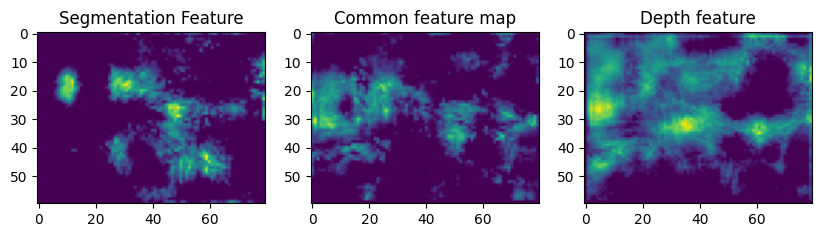

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10,10))
ax[0].imshow(seg_feature, cmap='viridis')
ax[0].set_title('Segmentation Feature')

ax[1].imshow(common_feature, cmap='viridis')
ax[1].set_title('Common feature map')

ax[2].imshow(depth_feature, cmap='viridis')
ax[2].set_title('Depth feature')

plt.show()

In [ ]:
depth_pred, seg_pred = model(image)

print(f'Result from model: {depth_pred.shape} (depth) | {seg_pred.shape}(seg)')

RuntimeError: [enforce fail at alloc_cpu.cpp:75] err == 0. DefaultCPUAllocator: can't allocate memory: you tried to allocate 78643200 bytes. Error code 12 (Cannot allocate memory)

In [ ]:
print(output)

tensor([[[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]]],


        [[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]]],


        [[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]]],


        ...,


        [[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, 

In [ ]:
up_features = [64, 32, 16]
inner_features = [64, 32, 16]

up_1 = Guided_Upsampling_Block(in_features=up_features[0],
                                   expand_features=inner_features[0],
                                   out_features=up_features[1],
                                   kernel_size=3,
                                   channel_attention=True,
                                   guide_features=3,
                                   guidance_type="full")

In [ ]:
img_quarter = F.interpolate(image, scale_factor=.25)
y = F.interpolate(feature_map, scale_factor=2, mode='bilinear')

print(f'Image to a quarter: {img_quarter.shape}')
print(f'Interpolated map to quarter: {y.shape}')

first_up = up_1(img_quarter, y)

print(f'First upsample block shape: {first_up.shape}')

Image to a quarter: torch.Size([8, 3, 120, 160])
Interpolated map to quarter: torch.Size([8, 64, 120, 160])
First upsample block shape: torch.Size([8, 32, 120, 160])
